In [4]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from matplotlib import style

In [31]:
def get_data(sample_num=2000):
    observed_r = np.random.uniform(low=0, high=5, size=(sample_num,)) # observed_r
    predicted_r = np.random.uniform(low=0, high=5, size=(sample_num,)) # predicted rating
    imputed_e = np.power((predicted_r - 0.5), 2)*0.3 ## e_hat_ui = 7*(r_ui - 5)^2
    
    observed_e = predicted_r - observed_r # e_ui
    propensities = np.random.uniform(low=0, high=1, size=(sample_num,)) # propensities for observed X_ui
   
    return observed_r, predicted_r, imputed_e, observed_e, propensities

2000

In [82]:
def SGD(predicted_r, imputed_e, observed_e, propensities, step_size=2, max_iter_count=2000):
    
    """
    :param samples: 样本
    :param y: 结果value
    :param step_size: 每一接迭代的步长
    :param max_iter_count: 最大的迭代次数
    :param batch_size: 随机选取的相对于总样本的大小
    :return:
    """
    m= predicted_r.shape[0]
    var = 1
    theta = np.zeros(2)
    imputed_e = imputed_e.flatten()
    loss = 1
    iter_count = 0
    iter_list=[]
    loss_list=[]
    theta1=[]
    theta2=[]
    
    while loss > 0.01 and iter_count < max_iter_count:
        loss = 0
        theta1.append(theta[0])
        theta2.append(theta[1])
        rand1 = np.random.randint(0,m,1)
        
        h = observed_e[rand1] # pick a random e_ui
        
        for i in range(len(theta)):
            theta[i] = theta[i] - step_size*(1/m)*(h - imputed_e[rand1])*predicted_r[rand1]
        for i in range(m):
            h = observed_e[i]
            every_loss = (1/(var*m))*np.power((h - y[i]), 2)/propensities[i]
            loss = loss + every_loss
            
        print("iter_count: ", iter_count, "the loss:", loss)
        
        iter_list.append(iter_count)
        loss_list.append(loss)
        
        iter_count += 1

    plt.plot(iter_list,loss_list)
    plt.xlabel("iter")
    plt.ylabel("loss")
    plt.show()
    return theta1,theta2,theta,loss_list

iter_count:  0 the loss: 346047.7446592375
iter_count:  1 the loss: 346047.7446592375
iter_count:  2 the loss: 346047.7446592375
iter_count:  3 the loss: 346047.7446592375
iter_count:  4 the loss: 346047.7446592375
iter_count:  5 the loss: 346047.7446592375
iter_count:  6 the loss: 346047.7446592375
iter_count:  7 the loss: 346047.7446592375
iter_count:  8 the loss: 346047.7446592375
iter_count:  9 the loss: 346047.7446592375
iter_count:  10 the loss: 346047.7446592375
iter_count:  11 the loss: 346047.7446592375
iter_count:  12 the loss: 346047.7446592375
iter_count:  13 the loss: 346047.7446592375
iter_count:  14 the loss: 346047.7446592375
iter_count:  15 the loss: 346047.7446592375
iter_count:  16 the loss: 346047.7446592375
iter_count:  17 the loss: 346047.7446592375
iter_count:  18 the loss: 346047.7446592375
iter_count:  19 the loss: 346047.7446592375
iter_count:  20 the loss: 346047.7446592375
iter_count:  21 the loss: 346047.7446592375
iter_count:  22 the loss: 346047.744659237

iter_count:  205 the loss: 346047.7446592375
iter_count:  206 the loss: 346047.7446592375
iter_count:  207 the loss: 346047.7446592375
iter_count:  208 the loss: 346047.7446592375
iter_count:  209 the loss: 346047.7446592375
iter_count:  210 the loss: 346047.7446592375
iter_count:  211 the loss: 346047.7446592375
iter_count:  212 the loss: 346047.7446592375
iter_count:  213 the loss: 346047.7446592375
iter_count:  214 the loss: 346047.7446592375
iter_count:  215 the loss: 346047.7446592375
iter_count:  216 the loss: 346047.7446592375
iter_count:  217 the loss: 346047.7446592375
iter_count:  218 the loss: 346047.7446592375
iter_count:  219 the loss: 346047.7446592375
iter_count:  220 the loss: 346047.7446592375
iter_count:  221 the loss: 346047.7446592375
iter_count:  222 the loss: 346047.7446592375
iter_count:  223 the loss: 346047.7446592375
iter_count:  224 the loss: 346047.7446592375
iter_count:  225 the loss: 346047.7446592375
iter_count:  226 the loss: 346047.7446592375
iter_count

iter_count:  456 the loss: 346047.7446592375
iter_count:  457 the loss: 346047.7446592375
iter_count:  458 the loss: 346047.7446592375
iter_count:  459 the loss: 346047.7446592375
iter_count:  460 the loss: 346047.7446592375
iter_count:  461 the loss: 346047.7446592375
iter_count:  462 the loss: 346047.7446592375
iter_count:  463 the loss: 346047.7446592375
iter_count:  464 the loss: 346047.7446592375
iter_count:  465 the loss: 346047.7446592375
iter_count:  466 the loss: 346047.7446592375
iter_count:  467 the loss: 346047.7446592375
iter_count:  468 the loss: 346047.7446592375
iter_count:  469 the loss: 346047.7446592375
iter_count:  470 the loss: 346047.7446592375
iter_count:  471 the loss: 346047.7446592375
iter_count:  472 the loss: 346047.7446592375
iter_count:  473 the loss: 346047.7446592375
iter_count:  474 the loss: 346047.7446592375
iter_count:  475 the loss: 346047.7446592375
iter_count:  476 the loss: 346047.7446592375
iter_count:  477 the loss: 346047.7446592375
iter_count

iter_count:  656 the loss: 346047.7446592375
iter_count:  657 the loss: 346047.7446592375
iter_count:  658 the loss: 346047.7446592375
iter_count:  659 the loss: 346047.7446592375
iter_count:  660 the loss: 346047.7446592375
iter_count:  661 the loss: 346047.7446592375
iter_count:  662 the loss: 346047.7446592375
iter_count:  663 the loss: 346047.7446592375
iter_count:  664 the loss: 346047.7446592375
iter_count:  665 the loss: 346047.7446592375
iter_count:  666 the loss: 346047.7446592375
iter_count:  667 the loss: 346047.7446592375
iter_count:  668 the loss: 346047.7446592375
iter_count:  669 the loss: 346047.7446592375
iter_count:  670 the loss: 346047.7446592375
iter_count:  671 the loss: 346047.7446592375
iter_count:  672 the loss: 346047.7446592375
iter_count:  673 the loss: 346047.7446592375
iter_count:  674 the loss: 346047.7446592375
iter_count:  675 the loss: 346047.7446592375
iter_count:  676 the loss: 346047.7446592375
iter_count:  677 the loss: 346047.7446592375
iter_count

iter_count:  1008 the loss: 346047.7446592375
iter_count:  1009 the loss: 346047.7446592375
iter_count:  1010 the loss: 346047.7446592375
iter_count:  1011 the loss: 346047.7446592375
iter_count:  1012 the loss: 346047.7446592375
iter_count:  1013 the loss: 346047.7446592375
iter_count:  1014 the loss: 346047.7446592375
iter_count:  1015 the loss: 346047.7446592375
iter_count:  1016 the loss: 346047.7446592375
iter_count:  1017 the loss: 346047.7446592375
iter_count:  1018 the loss: 346047.7446592375
iter_count:  1019 the loss: 346047.7446592375
iter_count:  1020 the loss: 346047.7446592375
iter_count:  1021 the loss: 346047.7446592375
iter_count:  1022 the loss: 346047.7446592375
iter_count:  1023 the loss: 346047.7446592375
iter_count:  1024 the loss: 346047.7446592375
iter_count:  1025 the loss: 346047.7446592375
iter_count:  1026 the loss: 346047.7446592375
iter_count:  1027 the loss: 346047.7446592375
iter_count:  1028 the loss: 346047.7446592375
iter_count:  1029 the loss: 346047

iter_count:  1243 the loss: 346047.7446592375
iter_count:  1244 the loss: 346047.7446592375
iter_count:  1245 the loss: 346047.7446592375
iter_count:  1246 the loss: 346047.7446592375
iter_count:  1247 the loss: 346047.7446592375
iter_count:  1248 the loss: 346047.7446592375
iter_count:  1249 the loss: 346047.7446592375
iter_count:  1250 the loss: 346047.7446592375
iter_count:  1251 the loss: 346047.7446592375
iter_count:  1252 the loss: 346047.7446592375
iter_count:  1253 the loss: 346047.7446592375
iter_count:  1254 the loss: 346047.7446592375
iter_count:  1255 the loss: 346047.7446592375
iter_count:  1256 the loss: 346047.7446592375
iter_count:  1257 the loss: 346047.7446592375
iter_count:  1258 the loss: 346047.7446592375
iter_count:  1259 the loss: 346047.7446592375
iter_count:  1260 the loss: 346047.7446592375
iter_count:  1261 the loss: 346047.7446592375
iter_count:  1262 the loss: 346047.7446592375
iter_count:  1263 the loss: 346047.7446592375
iter_count:  1264 the loss: 346047

iter_count:  1479 the loss: 346047.7446592375
iter_count:  1480 the loss: 346047.7446592375
iter_count:  1481 the loss: 346047.7446592375
iter_count:  1482 the loss: 346047.7446592375
iter_count:  1483 the loss: 346047.7446592375
iter_count:  1484 the loss: 346047.7446592375
iter_count:  1485 the loss: 346047.7446592375
iter_count:  1486 the loss: 346047.7446592375
iter_count:  1487 the loss: 346047.7446592375
iter_count:  1488 the loss: 346047.7446592375
iter_count:  1489 the loss: 346047.7446592375
iter_count:  1490 the loss: 346047.7446592375
iter_count:  1491 the loss: 346047.7446592375
iter_count:  1492 the loss: 346047.7446592375
iter_count:  1493 the loss: 346047.7446592375
iter_count:  1494 the loss: 346047.7446592375
iter_count:  1495 the loss: 346047.7446592375
iter_count:  1496 the loss: 346047.7446592375
iter_count:  1497 the loss: 346047.7446592375
iter_count:  1498 the loss: 346047.7446592375
iter_count:  1499 the loss: 346047.7446592375
iter_count:  1500 the loss: 346047

iter_count:  1716 the loss: 346047.7446592375
iter_count:  1717 the loss: 346047.7446592375
iter_count:  1718 the loss: 346047.7446592375
iter_count:  1719 the loss: 346047.7446592375
iter_count:  1720 the loss: 346047.7446592375
iter_count:  1721 the loss: 346047.7446592375
iter_count:  1722 the loss: 346047.7446592375
iter_count:  1723 the loss: 346047.7446592375
iter_count:  1724 the loss: 346047.7446592375
iter_count:  1725 the loss: 346047.7446592375
iter_count:  1726 the loss: 346047.7446592375
iter_count:  1727 the loss: 346047.7446592375
iter_count:  1728 the loss: 346047.7446592375
iter_count:  1729 the loss: 346047.7446592375
iter_count:  1730 the loss: 346047.7446592375
iter_count:  1731 the loss: 346047.7446592375
iter_count:  1732 the loss: 346047.7446592375
iter_count:  1733 the loss: 346047.7446592375
iter_count:  1734 the loss: 346047.7446592375
iter_count:  1735 the loss: 346047.7446592375
iter_count:  1736 the loss: 346047.7446592375
iter_count:  1737 the loss: 346047

iter_count:  1924 the loss: 346047.7446592375
iter_count:  1925 the loss: 346047.7446592375
iter_count:  1926 the loss: 346047.7446592375
iter_count:  1927 the loss: 346047.7446592375
iter_count:  1928 the loss: 346047.7446592375
iter_count:  1929 the loss: 346047.7446592375
iter_count:  1930 the loss: 346047.7446592375
iter_count:  1931 the loss: 346047.7446592375
iter_count:  1932 the loss: 346047.7446592375
iter_count:  1933 the loss: 346047.7446592375
iter_count:  1934 the loss: 346047.7446592375
iter_count:  1935 the loss: 346047.7446592375
iter_count:  1936 the loss: 346047.7446592375
iter_count:  1937 the loss: 346047.7446592375
iter_count:  1938 the loss: 346047.7446592375
iter_count:  1939 the loss: 346047.7446592375
iter_count:  1940 the loss: 346047.7446592375
iter_count:  1941 the loss: 346047.7446592375
iter_count:  1942 the loss: 346047.7446592375
iter_count:  1943 the loss: 346047.7446592375
iter_count:  1944 the loss: 346047.7446592375
iter_count:  1945 the loss: 346047

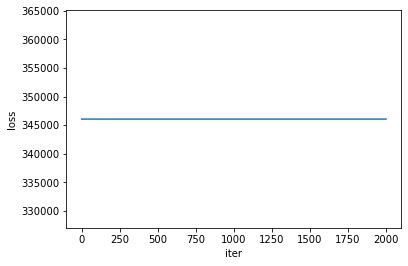

[9.9188339 9.9188339]


In [83]:
if __name__ == '__main__':
    observed_r, predicted_r, imputed_e, observed_e, propensities = get_data()
    theta1,theta2,theta,loss_list = SGD(predicted_r, imputed_e, observed_e, propensities)
    print(theta)